# Machine Learning Engineer Nanodegree

## Capstone Project

Daniel Bank
November 3rd, 2018

# Overview

## Photometric LSST Astronomical Time Series Classification Challenge

The Large Synoptic Survey Telescope (LSST), currently under construction in the Atacama desert of Chile, is the most awesome telescope that mankind will have built thus far in history.  It features an 8.4m mirror, 3.2 gigapixel camera, and 6.5m effective aperture [[1](#references)].  Every night, it will gather between 20 and 40 TB of image data of the southern sky.  While sifting through that much data to identify cosmological objects would be impractical for humans, it is a perfect use case for machine learning.

In preparation for the massive amounts of observations that will come from the LSST, an open data competition has been launched on [Kaggle](https://www.kaggle.com) called the Photometric LSST Astronomical Time Series Classification Challenge ([PLAsTiCC](https://www.kaggle.com/c/PLAsTiCC-2018)).  The goal of the challenge is to correctly classify time-varying cosmological objects in simulated astronomical time-series data similar to the data that the LSST will generate.

I first became aware of this challenge while browsing the Kaggle competitions.  My personal interest in astronomy stems partly from my background as a Physics major but more so from son, Arthur, who loves everything about the night sky.  He has taught me to really appreciate the beauty of the cosmos.

## Problem Statement

A

## Metrics

B

# Analysis

In [1]:
# Import Libraries and Configure Notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
from itertools import chain
import cesium.featurize as featurize
from gatspy.periodic import LombScargleMultiband, LombScargleMultibandFast
import pdb
import gc
import tensorflow as tf
import keras.backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Lambda
from keras.layers import GRU, Dense, Activation, Dropout, concatenate, Input, BatchNormalization
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from collections import Counter
import pickle
from tensorflow.python.client import timeline
import re
import time

%matplotlib inline
sns.set_style('whitegrid')
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', UserWarning)

Using TensorFlow backend.


In [2]:
# Load Training Data

train_series = pd.read_csv('../input/training_set.csv')
train_metadata = pd.read_csv('../input/training_set_metadata.csv')

## Data Exploration

One interesting observation is that classes in the training data set divide evenly into intragalactic and extragalactic categories.  There are no classes that are present in both categories.  Class 99 (the unknown classification) is not present at all in the training dataset.  This last point raises an interesting challenge for our model:  How to predict this mystery class when it is not present at all in the training data?  We will investigate possible solutions to this in the following **Algorithms and Techniques** section.

Another challenge is that the training dataset is a small subset of the test dataset and is also a poor representation of it.  This design decision was made to imitate the real-world challenges that astronomers face when trying to classify cosmological objects.

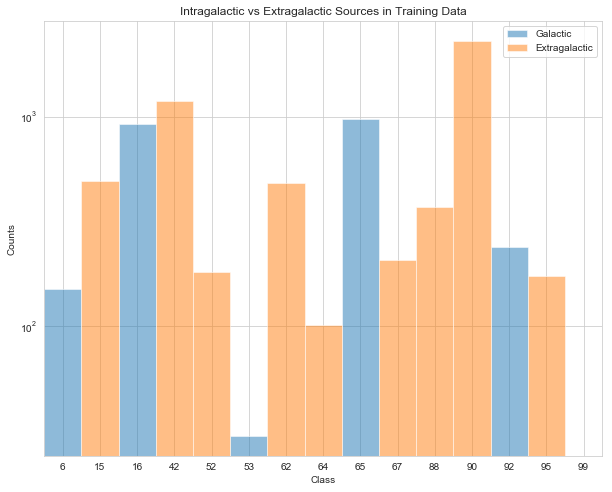

In [3]:
# Galactic vs Extragalactic Code by Kyle Boone
# https://www.kaggle.com/kyleboone/naive-benchmark-galactic-vs-extragalactic

targets = np.hstack([np.unique(train_metadata['target']), [99]])
target_map = {j:i for i, j in enumerate(targets)}
target_ids = [target_map[i] for i in train_metadata['target']]
train_metadata['target_id'] = target_ids

# Intragalactic sources have no redshift! (hostgal_spez == 0)
intragalactic_cut = train_metadata['hostgal_specz'] == 0.
plt.figure(figsize=(10, 8))
plt.hist(train_metadata[intragalactic_cut]['target_id'], 15, (0, 15), alpha=0.5, label='Galactic')
plt.hist(train_metadata[~intragalactic_cut]['target_id'], 15, (0, 15), alpha=0.5, label='Extragalactic')
plt.xticks(np.arange(15)+0.5, targets)
plt.gca().set_yscale("log")
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim(0, 15)
plt.title('Intragalactic vs Extragalactic Sources in Training Data')
plt.legend();

## Exploratory Visualization

It is helpful to look at the example passband data for the various classes to get an understanding of what the data looks like and understand some of the distinguishing features between classes.  As there are 14 classes represented in the training dataset, we will only examine two of the more interesting classes: Class 92 and Class 42.  Class 92 are highly periodic while Class 42 exhibit what appear to be "burst" events with diminishing activity after that.  The author of this code, [Mithrillion](https://www.kaggle.com/mithrillion), theorizes that Class 92 are regular variable stars and Class 42 are supernovae events.

In [4]:
# Visualization Code by Mithrillion
# https://www.kaggle.com/mithrillion/all-classes-light-curve-characteristics-updated

groups = train_series.groupby(['object_id', 'passband'])
times = groups.apply(
    lambda block: block['mjd'].values).reset_index().rename(columns={0: 'seq'})
flux = groups.apply(
    lambda block: block['flux'].values
).reset_index().rename(columns={0: 'seq'})
err = groups.apply(
    lambda block: block['flux_err'].values
).reset_index().rename(columns={0: 'seq'})
det = groups.apply(
    lambda block: block['detected'].astype(bool).values
).reset_index().rename(columns={0: 'seq'})
times_list = times.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
flux_list = flux.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
err_list = err.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
det_list = det.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()

def fit_multiband_freq(tup):
    idx, group = tup
    t, f, e, b = group['mjd'], group['flux'], group['flux_err'], group['passband']
    model = LombScargleMultiband(fit_period=True)
    model.optimizer.period_range = (0.1, int((group['mjd'].max() - group['mjd'].min()) / 2))
    model.fit(t, f, e, b)
    return model

def get_freq_features(N, subsetting_pos=None):
    if subsetting_pos is None:
        subset_times_list = times_list
        subset_flux_list = flux_list
    else:
        subset_times_list = [v for i, v in enumerate(times_list) 
                             if i in set(subsetting_pos)]
        subset_flux_list = [v for i, v in enumerate(flux_list) 
                            if i in set(subsetting_pos)]
    feats = featurize.featurize_time_series(times=subset_times_list[:N],
                                            values=subset_flux_list[:N],
                                            features_to_use=['skew',
                                                            'percent_beyond_1_std',
                                                            'percent_difference_flux_percentile'
                                                            ],
                                            scheduler=None)
    subset = train_series[train_series['object_id'].isin(
        train_metadata['object_id'].iloc[subsetting_pos].iloc[:N])]
    models = list(map(fit_multiband_freq, subset.groupby('object_id')))
    feats['object_pos'] = subsetting_pos[:N]
    feats['freq1_freq'] = [model.best_period for model in models]
    return feats, models

unique_classes = train_metadata['target'].unique()

def get_class_feats(label, N=10):
    class_pos = train_metadata[train_metadata['target'] == label].index
    class_feats, class_models = get_freq_features(N, class_pos)
    return class_feats, class_models

def plot_phase_curves(feats, models, use_median_freq=False, hide_undetected=True, N=10):
    for i in range(N):
        freq = feats.loc[i, 'freq1_freq'].median()
        freq_min = feats.loc[i, 'freq1_freq'].min()
        freq_std = feats.loc[i, 'freq1_freq'].std()
        skew = feats.loc[i, 'skew'].mean()
        object_pos = int(feats.loc[i, 'object_pos'][0])
        f, ax = plt.subplots(1, 2, figsize=(14, 4))
        sample = train_series[train_series['object_id'] ==
                              train_metadata['object_id'].iloc[object_pos]].copy()
        colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
        score = models[i].score(models[i].best_period)
        
        ax[0].scatter(x=sample['mjd'], 
                   y=sample['flux'], 
                   c=[colors[b] for b in sample['passband']],
                   s=8, alpha=0.8)
        ax[0].vlines(sample['mjd'], 
                  sample['flux'] - sample['flux_err'],
                  sample['flux'] + sample['flux_err'],
                  colors=[colors[b] for b in sample['passband']],
                  linewidth=1, alpha=0.8)
        
        sample['phase'] = (sample['mjd'] / models[i].best_period) % 1
        ax[1].scatter(x=sample['phase'], 
                   y=sample['flux'], 
                   c=[colors[b] for b in sample['passband']],
                   s=8, alpha=0.8)
        ax[1].vlines(sample['phase'], 
                  sample['flux'] - sample['flux_err'],
                  sample['flux'] + sample['flux_err'],
                  colors=[colors[b] for b in sample['passband']],
                  linewidth=1, alpha=0.8)
        x_range = np.linspace(sample['mjd'].min(), sample['mjd'].max(), 1000)
        for band in range(6):
            y = models[i].predict(x_range, band)
            xs = (x_range / models[i].best_period) % 1
            ords = np.argsort(xs)
            ax[1].plot(xs[ords], y[ords], c=colors[band], alpha=0.4)
        
        title = ax[0].get_title()
        ax[0].set_title('time')
        ax[1].set_title('phase')
        f.suptitle(title + f'object: {sample["object_id"].iloc[0]}, '
                   f'class: {train_metadata["target"].iloc[object_pos]}\n'
                   f'period: {models[i].best_period: .4}, '
                   f'period score: {score: .4}, '
                   f'mean skew: {skew:.4}', y=1.1)
        plt.show()

In [5]:
%%capture capt
feats, models = get_class_feats(92)

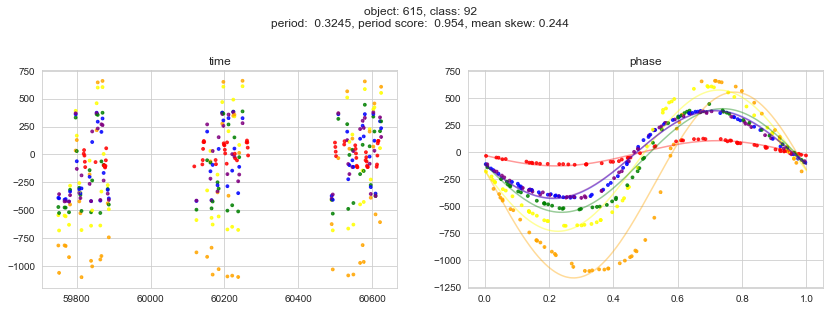

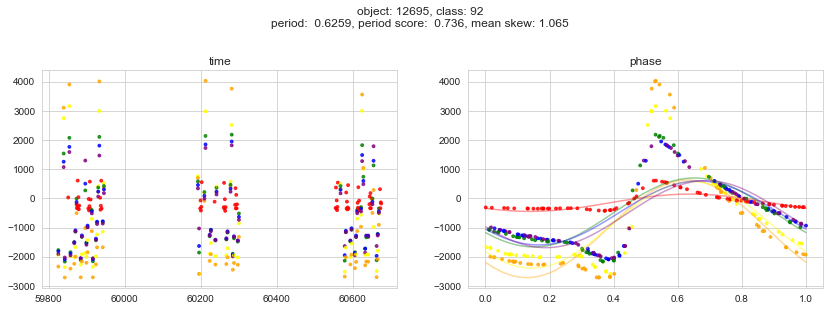

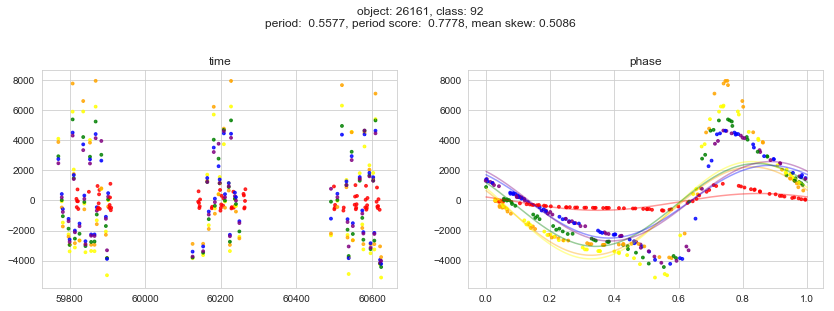

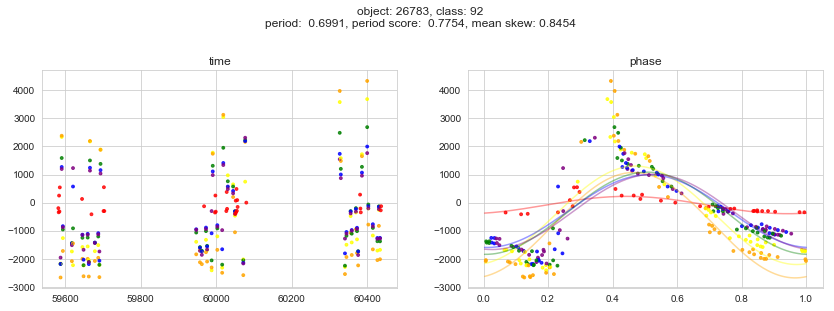

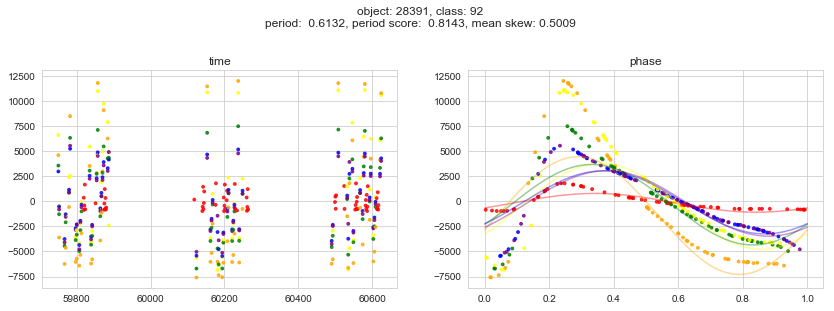

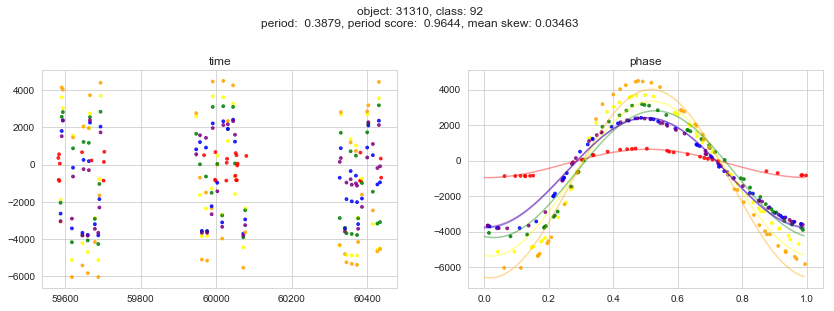

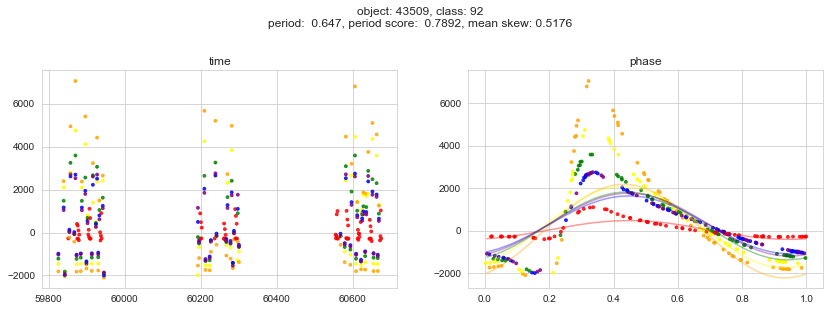

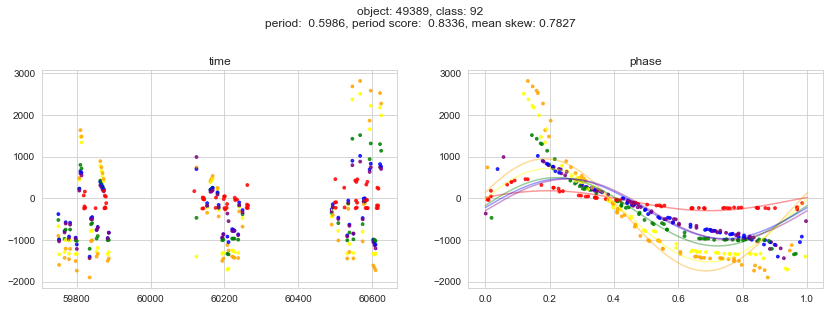

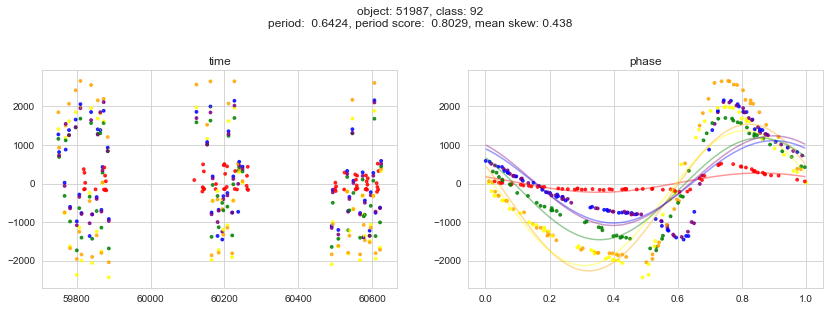

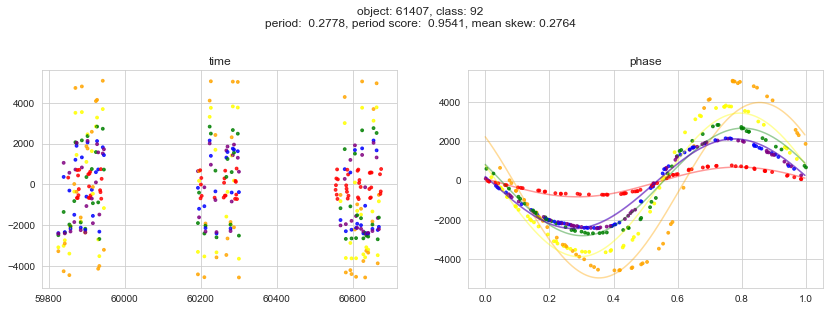

In [6]:
plot_phase_curves(feats, models)

In [7]:
%%capture capt
feats, models = get_class_feats(42)

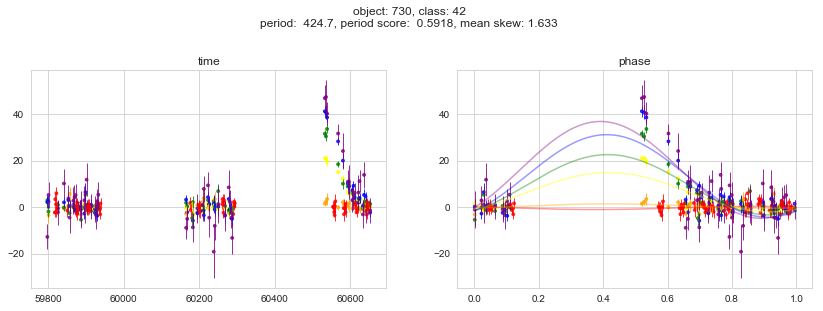

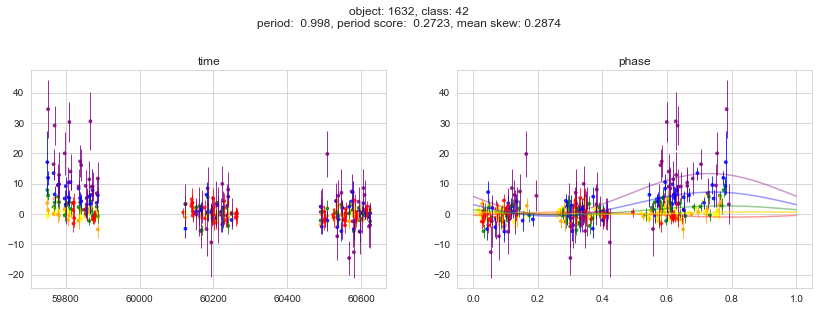

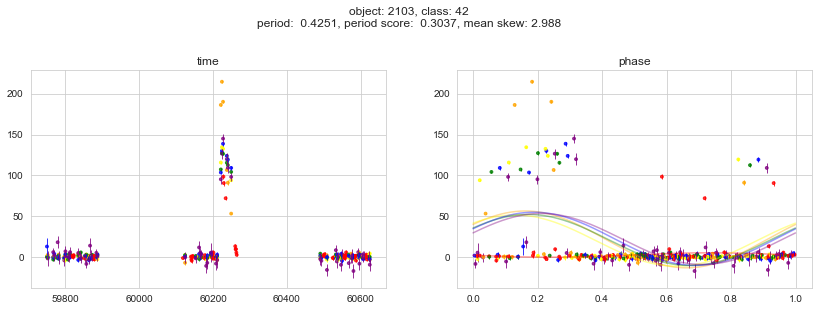

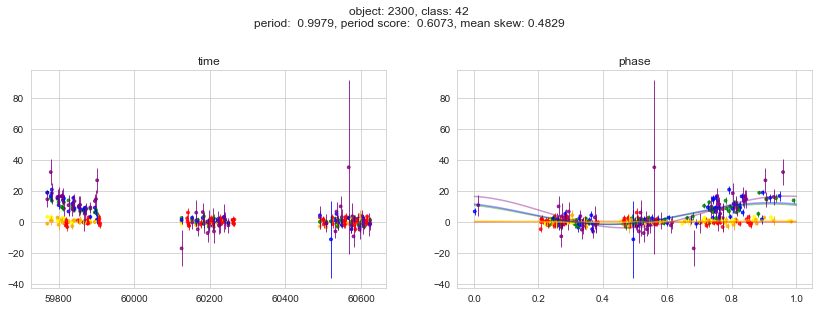

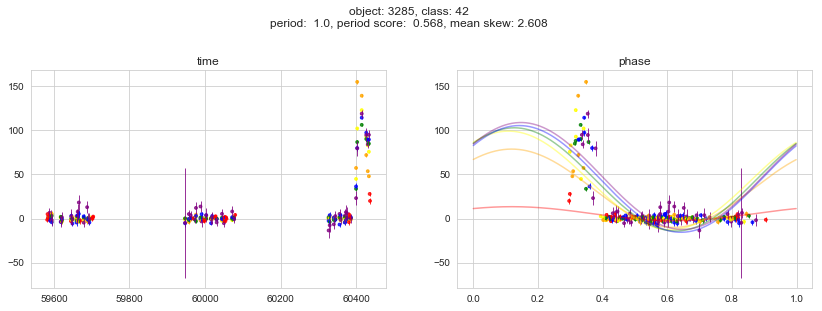

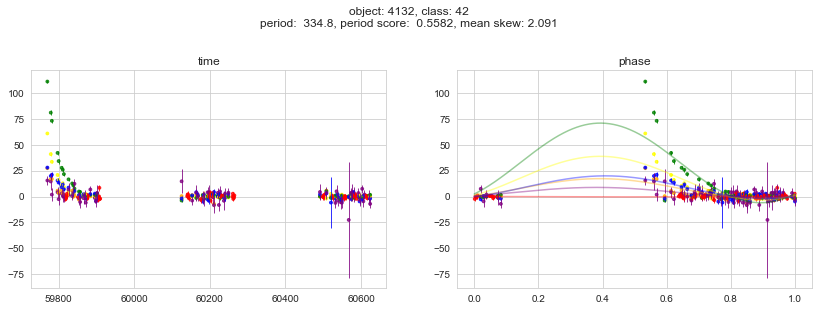

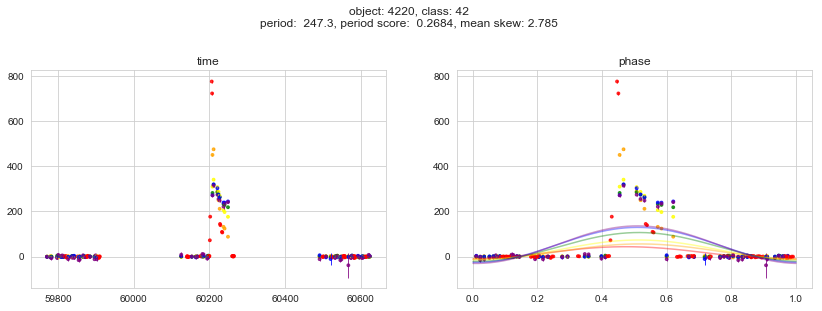

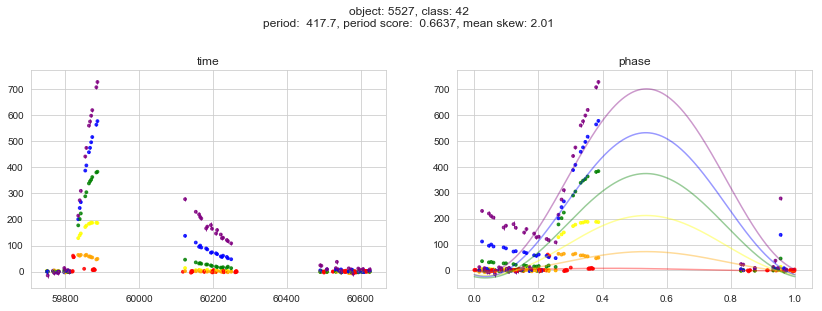

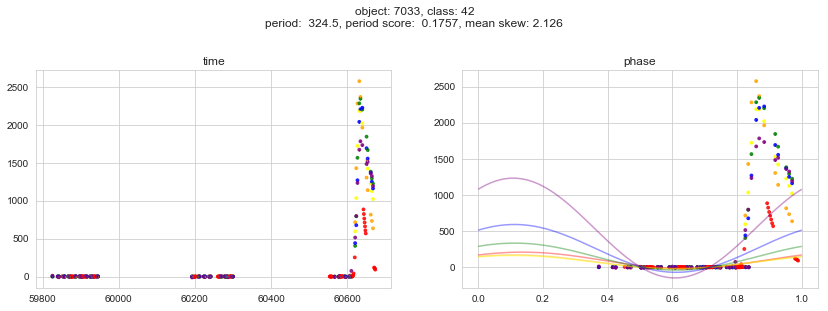

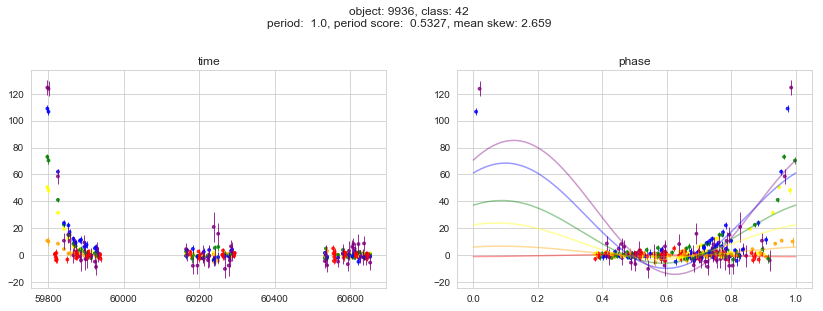

In [8]:
plot_phase_curves(feats, models)

## Algorithms and Techniques

- Partition data along intra- extra-galactic
- How to handle class 99?  DBScan?  Something else?
- Learning model (CNN...)
- PCA?

## Benchmark
The PLAsTiCC team has provided a [naive classifier](https://www.kaggle.com/michaelapers/the-plasticc-astronomy-classification-demo) for the challenge.  The naive classifier is designed as follows:

1. The raw tabular data is converted into a form suitable for analysis.  Using the `cesium` package for Python, `Timeseries` objects are constructed for each light curve.
2. The data is split into a training and test set.
3. The dimensionality of the training data is reduced using Principle Component Analysis (PCA).  The result of this step are features which are linear combinations of the `passband` data.  With just eight (8) features, we can account for almost all of the explained variance.
4. The reduced dataset is fit with a `RandomForestClassifier`.

### Evaluation Metrics

The performance of the naive classifier on the test data can be visualized in the following confusion matrix:

![Naive Classifier Confusion Matrix](https://github.com/danielbank/PLAsTiCC/blob/master/.github/naive_classifier_confusion_matrix.png?raw=true)

In this matrix, we can see the model's predicted labels versus the true labels for the test set.  Ideally, this confusion matrix would be the Identity matrix, with all values along the diagonal being 1 and everything else being 0.  That would mean that the model predicted the correct label 100% of the time.

When designing my classifier, I will generate a similar confusion matrix so that my results can be objectively compared to the naive classifier.  My objective is to have an average prediction accuracy per label that is higher than the naive classifier's accuracy of 0.518 (see calculation below):

```
(1.00 + 0.06 + 0.31 + 0.23 + 0.02 +
 0.19 + 0.86 + 0.76 + 0.34 + 0.59 +
 0.96 + 0.70 + 0.36 + 0.87) / 14
= 0.518
```

# PLAsTiCC Prediction Pipeline

Using [Higepon's CNN based model](https://www.kaggle.com/higepon/keras-cnn-use-time-series-data-as-is) as a starting point, we design our prediction pipeline as follows:

1. Data Preprocessing: specific features are scaled using a `StandardScaler`
2. Partitioning Intragalactic and Extragalactic Sources

.
.
.

3. Both segmented datasets are used to train separate CNNs


## Data Preprocessing

The data for this challenge has been provided in a curated form by the PLAsTiCC Team.  As such most data preprocessing techniques, like defaulting missing data or one-hot encoding text categories, are not required for our pipeline.  We do use `sklearn.preprocessing.StandardScaler` to scale features to unit variance which is helpful for CNN training.

In [9]:
scaler = StandardScaler()
train_series[['mjd', 'flux', 'flux_err']] = scaler.fit_transform(train_series[['mjd', 'flux', 'flux_err']])
train_series = train_series.sort_values(['object_id', 'passband', 'mjd'])
train_series.head()

,object_id,mjd,passband,flux,flux_err,detected
54,615,-1.164326,0,-0.004834,-0.005730,0
55,615,-1.161249,0,0.003983,-0.005692,1
56,615,-1.158022,0,-0.009529,-0.005588,0
57,615,-1.154763,0,-0.024474,-0.005538,1
58,615,-1.151400,0,-0.037464,-0.005616,1


## Partitioning Intragalactic and Extragalactic Sources

As we saw in the Data Exploration section, we can narrow number of possible classifications of the training data to 5 out of 14 possibilities for galactic sources and 9 out of 14 possibilities for extragalactic sources.  It makes sense to partition our data along these lines.

In [10]:
# Partition the Training Data (Intragalactic vs Extragalactic)

intragal_metadata = train_metadata[train_metadata['hostgal_specz'] == 0.]
intragal_series = train_series[np.in1d(train_series['object_id'], intragal_metadata['object_id'])]

extragal_metadata = train_metadata[train_metadata['hostgal_specz'] != 0.]
extragal_series = train_series[np.in1d(train_series['object_id'], extragal_metadata['object_id'])]

print('Length of Intragalactic Metadata: ', len(intragal_metadata))
print('Length of Extragalactic Metadata: ', len(extragal_metadata))

Length of Intragalactic Metadata:  2325
Length of Extragalactic Metadata:  5523


In [11]:
train_intragal_timeseries = intragal_series.groupby(['object_id', 'passband'])['flux', 'flux_err', 'detected'].apply(lambda df: df.reset_index(drop=True)).unstack()
train_intragal_timeseries.fillna(0, inplace=True)
train_intragal_timeseries.columns = ['_'.join(map(str,tup)).rstrip('_') for tup in train_intragal_timeseries.columns.values]

train_extragal_timeseries = extragal_series.groupby(['object_id', 'passband'])['flux', 'flux_err', 'detected'].apply(lambda df: df.reset_index(drop=True)).unstack()
train_extragal_timeseries.fillna(0, inplace=True)
train_extragal_timeseries.columns = ['_'.join(map(str,tup)).rstrip('_') for tup in train_extragal_timeseries.columns.values]
train_extragal_timeseries.head(7)

flux_0    flux_1    flux_2    flux_3    flux_4  \
object_id passband                                                     
713       0        -0.004728 -0.005569 -0.005976 -0.006797 -0.006067   
          1        -0.004634 -0.005851 -0.005095 -0.005898 -0.007304   
          2        -0.004228 -0.005356 -0.004944 -0.005630 -0.005632   
          3        -0.004889 -0.005043 -0.005259 -0.005406 -0.006830   
          4        -0.005285 -0.004452 -0.005430 -0.005597 -0.004515   
          5        -0.003427 -0.004072 -0.004822 -0.006350 -0.009233   
730       0        -0.007336 -0.005783 -0.007306 -0.006386 -0.005088   

                      flux_5    flux_6    flux_7    flux_8    flux_9  \
object_id passband                                                     
713       0        -0.005670 -0.005371 -0.006339 -0.005826 -0.002763   
          1        -0.006275 -0.005897 -0.005519 -0.006236 -0.005691   
          2        -0.006326 -0.005777 -0.005650 -0.005862 -0.005340   
          3        -0.006312 -0.005996 -0.005900 -0.006008 -0.003977   
          4        -0.005262 -0.005939 -0.005855 -0.006131 -0.005082   
          5        -0.006061 -0.005859 -0.005612 -0.005130 -0.004306   
730       0        -0.006750 -0.007100 -0.006589 -0.007298 -0.007496   

                       ...       detected_62  detected_63  detected_64  \
object_id passband     ...                                               
713       0            ...               0.0          0.0          1.0   
          1            ...               0.0          0.0          0.0   
          2            ...               0.0          0.0          0.0   
          3            ...               0.0          0.0          0.0   
          4            ...               0.0          0.0          0.0   
          5            ...               0.0          0.0          0.0   
730       0            ...               0.0          0.0          0.0   

                    detected_65  detected_66  detected_67  detected_68  \
object_id passband                                                       
713       0                 0.0          1.0          1.0          0.0   
          1                 0.0          0.0          0.0          0.0   
          2                 0.0          0.0          0.0          0.0   
          3                 0.0          0.0          0.0          0.0   
          4                 0.0          0.0          0.0          0.0   
          5                 0.0          0.0          0.0          0.0   
730       0                 0.0          0.0          0.0          0.0   

                    detected_69  detected_70  detected_71  
object_id passband                                         
713       0                 0.0          0.0          0.0  
          1                 0.0          0.0          0.0  
          2                 0.0          0.0          0.0  
          3                 0.0          0.0          0.0  
          4                 0.0          0.0          0.0  
          5                 0.0          0.0          0.0  
730       0                 0.0          0.0          0.0  

[7 rows x 216 columns]

In [12]:
num_columns_intragal = len(train_intragal_timeseries.columns)
num_columns_extragal = len(train_extragal_timeseries.columns)
print('Number of Columns for Intragalactic Time Series Data: ', num_columns_intragal)
print('Number of Columns for Extragalactic Time Series Data: ', num_columns_extragal)

Number of Columns for Intragalactic Time Series Data:  216
Number of Columns for Extragalactic Time Series Data:  216


In [13]:
X_intragal_train = train_intragal_timeseries.values.reshape(-1, 6, num_columns_intragal).transpose(0, 2, 1)
X_extragal_train = train_extragal_timeseries.values.reshape(-1, 6, num_columns_extragal).transpose(0, 2, 1)
X_extragal_train

array([[[-0.00472815, -0.00463387, -0.00422809, -0.00488937,
         -0.00528548, -0.00342722],
        [-0.00556853, -0.00585086, -0.00535635, -0.00504269,
         -0.00445237, -0.00407166],
        [-0.00597559, -0.00509531, -0.004944  , -0.00525902,
         -0.00543021, -0.0048221 ],
        ...,
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ]],

       [[-0.00733633, -0.00607075, -0.0063811 , -0.00590286,
         -0.00612306, -0.01017727],
        [-0.00578302, -0.00762155, -0.00667045, -0.0072161 ,
         -0.0060805 , -0.0052884 ],
        [-0.0073061 , -0.00708652, -0.00655899, -0.00643674,
         -0.00685542, -0.00732522],
        ...,
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
  

In [14]:
intragal_classes = sorted(intragal_metadata.target.unique())
class_intragal_map = dict()
for i,val in enumerate(intragal_classes):
    class_intragal_map[val] = i

extragal_classes = sorted(extragal_metadata.target.unique())
class_extragal_map = dict()
for i,val in enumerate(extragal_classes):
    class_extragal_map[val] = i

print('Intragalactic Classes Dictionary: ', class_intragal_map)
print('Extragalactic Classes Dictionary: ', class_extragal_map)

Intragalactic Classes Dictionary:  {6: 0, 16: 1, 53: 2, 65: 3, 92: 4}
Extragalactic Classes Dictionary:  {15: 0, 42: 1, 52: 2, 62: 3, 64: 4, 67: 5, 88: 6, 90: 7, 95: 8}


In [15]:
train_intragal_timeseries0 = train_intragal_timeseries.reset_index()
train_intragal_timeseries0 = train_intragal_timeseries0[train_intragal_timeseries0.passband == 0]

train_extragal_timeseries0 = train_extragal_timeseries.reset_index()
train_extragal_timeseries0 = train_extragal_timeseries0[train_extragal_timeseries0.passband == 0]

train_extragal_timeseries0.head()

,object_id,passband,flux_0,flux_1,flux_2,flux_3,flux_4,flux_5,flux_6,flux_7,...,detected_62,detected_63,detected_64,detected_65,detected_66,detected_67,detected_68,detected_69,detected_70,detected_71
0,713,0,-0.004728,-0.005569,-0.005976,-0.006797,-0.006067,-0.005670,-0.005371,-0.006339,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6,730,0,-0.007336,-0.005783,-0.007306,-0.006386,-0.005088,-0.006750,-0.007100,-0.006589,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,745,0,-0.006555,-0.006034,-0.006587,-0.007031,-0.005994,-0.005709,-0.006772,-0.006965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,1124,0,-0.006798,-0.005864,-0.007726,-0.006574,-0.008547,-0.006898,-0.006172,-0.006554,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,1598,0,-0.007197,-0.006749,-0.007172,-0.008614,-0.006197,-0.007218,-0.006919,-0.006981,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
merged_intragal_metadata = train_intragal_timeseries0.merge(intragal_metadata, on='object_id', how='left')
merged_intragal_metadata.fillna(0, inplace=True)

merged_extragal_metadata = train_extragal_timeseries0.merge(extragal_metadata, on='object_id', how='left')
merged_extragal_metadata.fillna(0, inplace=True)

In [17]:
y_intragal = merged_intragal_metadata.target
classes_intragal = sorted(y_intragal.unique())

y_extragal = merged_extragal_metadata.target
classes_extragal = sorted(y_extragal.unique())

print('Unique Intragalactic Classes: ', classes_intragal)
print('Unique Extragalactic Classes: ', classes_extragal)

Unique Intragalactic Classes:  [6, 16, 53, 65, 92]
Unique Extragalactic Classes:  [15, 42, 52, 62, 64, 67, 88, 90, 95]


In [18]:
targets_intragal = merged_intragal_metadata.target
target_intragal_map = np.zeros((targets_intragal.shape[0],))
target_intragal_map = np.array([class_intragal_map[val] for val in targets_intragal])
Y_intragal = to_categorical(target_intragal_map)

targets_extragal = merged_extragal_metadata.target
target_extragal_map = np.zeros((targets_extragal.shape[0],))
target_extragal_map = np.array([class_extragal_map[val] for val in targets_extragal])
Y_extragal = to_categorical(target_extragal_map)
Y_extragal.shape

(5523, 9)

In [19]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('Model Loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('Model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

In [20]:
batch_size = 256

def weight_variable(shape, name=None):
    return np.random.normal(scale=.01, size=shape)

def build_model(X_train, classes):
    input = Input(shape=(X_train.shape[1], 6), dtype='float32', name='input0')
    output = Conv1D(256,
                 kernel_size=80,
                 strides=4,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001))(input)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = MaxPooling1D(pool_size=4, strides=None)(output)
    output = Conv1D(256,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001))(output)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = MaxPooling1D(pool_size=4, strides=None)(output)
    output = Lambda(lambda x: K.mean(x, axis=1))(output) # Same as GAP for 1D Conv Layer
    output = Dense(len(classes), activation='softmax')(output)
    model = Model(inputs=input, outputs=output)
    return model

# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69795
def mywloss(y_true,y_pred):
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

Train on 4416 samples, validate on 1107 samples
Epoch 1/1000
4416/4416 [==============================] - 3s 725us/step - loss: 1.8841 - acc: 0.2629 - val_loss: 2.0197 - val_acc: 0.1807
Epoch 2/1000
4416/4416 [==============================] - 3s 587us/step - loss: 1.5594 - acc: 0.2568 - val_loss: 1.8201 - val_acc: 0.2376
Epoch 3/1000
4416/4416 [==============================] - 3s 596us/step - loss: 1.4074 - acc: 0.3093 - val_loss: 1.6578 - val_acc: 0.2358
Epoch 4/1000
4416/4416 [==============================] - 3s 598us/step - loss: 1.2345 - acc: 0.3687 - val_loss: 1.7612 - val_acc: 0.3261
Epoch 5/1000
4416/4416 [==============================] - 3s 604us/step - loss: 1.0600 - acc: 0.4407 - val_loss: 1.8995 - val_acc: 0.3369
Epoch 6/1000
4416/4416 [==============================] - 3s 609us/step - loss: 0.9646 - acc: 0.4937 - val_loss: 1.8773 - val_acc: 0.2042
Epoch 7/1000
4416/4416 [==============================] - 3s 613us/step - loss: 0.8444 - acc: 0.5190 - val_loss: 1.8705 - va

4416/4416 [==============================] - 3s 612us/step - loss: 0.1427 - acc: 0.9454 - val_loss: 5.2198 - val_acc: 0.5185
Epoch 60/1000
4416/4416 [==============================] - 3s 612us/step - loss: 0.1354 - acc: 0.9434 - val_loss: 3.1301 - val_acc: 0.3306
Epoch 61/1000
4416/4416 [==============================] - 3s 610us/step - loss: 0.1193 - acc: 0.9567 - val_loss: 4.7158 - val_acc: 0.4878
Epoch 62/1000
4416/4416 [==============================] - 3s 611us/step - loss: 0.1257 - acc: 0.9450 - val_loss: 2.4198 - val_acc: 0.3162
Epoch 63/1000
4416/4416 [==============================] - 3s 605us/step - loss: 0.1107 - acc: 0.9669 - val_loss: 5.1071 - val_acc: 0.5023


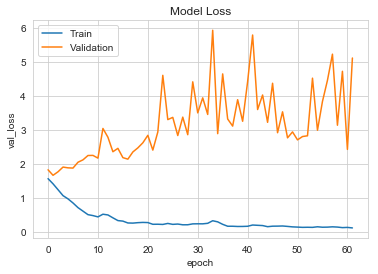

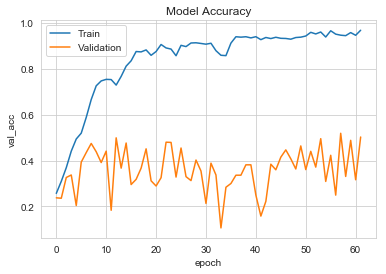

Loading Best Model
Train on 4416 samples, validate on 1107 samples
Epoch 1/1000
4416/4416 [==============================] - 3s 755us/step - loss: 1.8929 - acc: 0.2262 - val_loss: 2.1604 - val_acc: 0.1563
Epoch 2/1000
4416/4416 [==============================] - 3s 602us/step - loss: 1.5570 - acc: 0.2720 - val_loss: 1.8391 - val_acc: 0.2023
Epoch 3/1000
4416/4416 [==============================] - 3s 603us/step - loss: 1.4070 - acc: 0.3152 - val_loss: 1.7524 - val_acc: 0.2132
Epoch 4/1000
4416/4416 [==============================] - 3s 605us/step - loss: 1.2523 - acc: 0.3777 - val_loss: 1.8313 - val_acc: 0.2349
Epoch 5/1000
4416/4416 [==============================] - 3s 606us/step - loss: 1.0691 - acc: 0.4719 - val_loss: 1.9284 - val_acc: 0.2719
Epoch 6/1000
4416/4416 [==============================] - 3s 611us/step - loss: 0.8577 - acc: 0.5412 - val_loss: 2.0537 - val_acc: 0.2809
Epoch 7/1000
4416/4416 [==============================] - 3s 609us/step - loss: 0.7183 - acc: 0.6284 - va

4416/4416 [==============================] - 3s 614us/step - loss: 0.1617 - acc: 0.9402 - val_loss: 3.5490 - val_acc: 0.3631
Epoch 60/1000
4416/4416 [==============================] - 3s 616us/step - loss: 0.1575 - acc: 0.9416 - val_loss: 5.3564 - val_acc: 0.4770
Epoch 61/1000
4416/4416 [==============================] - 3s 613us/step - loss: 0.1655 - acc: 0.9169 - val_loss: 3.0132 - val_acc: 0.3035
Epoch 62/1000
4416/4416 [==============================] - 3s 610us/step - loss: 0.1509 - acc: 0.9307 - val_loss: 5.4764 - val_acc: 0.4706
Epoch 63/1000
4416/4416 [==============================] - 3s 606us/step - loss: 0.1649 - acc: 0.9262 - val_loss: 3.2445 - val_acc: 0.2746


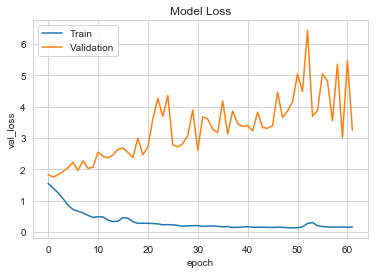

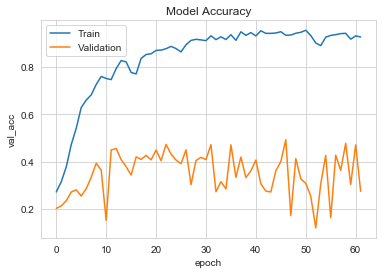

Loading Best Model
Train on 4417 samples, validate on 1106 samples
Epoch 1/1000
4417/4417 [==============================] - 3s 771us/step - loss: 1.9119 - acc: 0.1974 - val_loss: 1.9727 - val_acc: 0.2116
Epoch 2/1000
4417/4417 [==============================] - 3s 600us/step - loss: 1.5861 - acc: 0.2547 - val_loss: 1.7922 - val_acc: 0.2025
Epoch 3/1000
4417/4417 [==============================] - 3s 608us/step - loss: 1.4155 - acc: 0.3086 - val_loss: 1.8053 - val_acc: 0.1790
Epoch 4/1000
4417/4417 [==============================] - 3s 609us/step - loss: 1.2756 - acc: 0.3559 - val_loss: 1.7660 - val_acc: 0.2351
Epoch 5/1000
4417/4417 [==============================] - 3s 611us/step - loss: 1.1072 - acc: 0.4358 - val_loss: 1.8172 - val_acc: 0.3282
Epoch 6/1000
4417/4417 [==============================] - 3s 607us/step - loss: 0.9154 - acc: 0.5200 - val_loss: 1.9288 - val_acc: 0.3409
Epoch 7/1000
4417/4417 [==============================] - 3s 612us/step - loss: 0.7537 - acc: 0.6004 - va

4417/4417 [==============================] - 3s 617us/step - loss: 0.1098 - acc: 0.9647 - val_loss: 5.8112 - val_acc: 0.2776
Epoch 60/1000
4417/4417 [==============================] - 3s 614us/step - loss: 0.1178 - acc: 0.9563 - val_loss: 2.9575 - val_acc: 0.2911
Epoch 61/1000
4417/4417 [==============================] - 3s 611us/step - loss: 0.1182 - acc: 0.9692 - val_loss: 5.4109 - val_acc: 0.3309
Epoch 62/1000
4417/4417 [==============================] - 3s 605us/step - loss: 0.1370 - acc: 0.9536 - val_loss: 3.2073 - val_acc: 0.2514
Epoch 63/1000
4417/4417 [==============================] - 3s 608us/step - loss: 0.1329 - acc: 0.9608 - val_loss: 4.7031 - val_acc: 0.3617
Epoch 64/1000
4417/4417 [==============================] - 3s 618us/step - loss: 0.1507 - acc: 0.9427 - val_loss: 2.9827 - val_acc: 0.2712


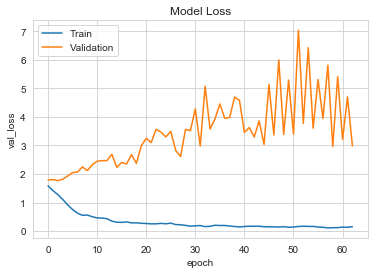

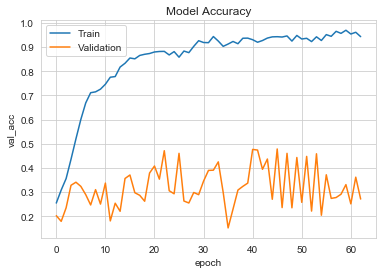

Loading Best Model
Train on 4421 samples, validate on 1102 samples
Epoch 1/1000
4421/4421 [==============================] - 3s 787us/step - loss: 1.8962 - acc: 0.2289 - val_loss: 2.0494 - val_acc: 0.2387
Epoch 2/1000
4421/4421 [==============================] - 3s 598us/step - loss: 1.5173 - acc: 0.2809 - val_loss: 1.7934 - val_acc: 0.3330
Epoch 3/1000
4421/4421 [==============================] - 3s 606us/step - loss: 1.3586 - acc: 0.3302 - val_loss: 1.7500 - val_acc: 0.2731
Epoch 4/1000
4421/4421 [==============================] - 3s 606us/step - loss: 1.1796 - acc: 0.4146 - val_loss: 1.8203 - val_acc: 0.2659
Epoch 5/1000
4421/4421 [==============================] - 3s 608us/step - loss: 1.0238 - acc: 0.4770 - val_loss: 1.8197 - val_acc: 0.1987
Epoch 6/1000
4421/4421 [==============================] - 3s 607us/step - loss: 0.8868 - acc: 0.5404 - val_loss: 1.8823 - val_acc: 0.2278
Epoch 7/1000
4421/4421 [==============================] - 3s 610us/step - loss: 0.7438 - acc: 0.5960 - va

4421/4421 [==============================] - 3s 632us/step - loss: 0.0948 - acc: 0.9742 - val_loss: 3.0344 - val_acc: 0.4002
Epoch 60/1000
4421/4421 [==============================] - 3s 608us/step - loss: 0.0937 - acc: 0.9740 - val_loss: 3.1920 - val_acc: 0.4356
Epoch 61/1000
4421/4421 [==============================] - 3s 609us/step - loss: 0.1002 - acc: 0.9776 - val_loss: 3.9086 - val_acc: 0.3067
Epoch 62/1000
4421/4421 [==============================] - 3s 617us/step - loss: 0.1086 - acc: 0.9679 - val_loss: 4.1709 - val_acc: 0.3503
Epoch 63/1000
4421/4421 [==============================] - 3s 620us/step - loss: 0.0988 - acc: 0.9756 - val_loss: 3.3681 - val_acc: 0.3004


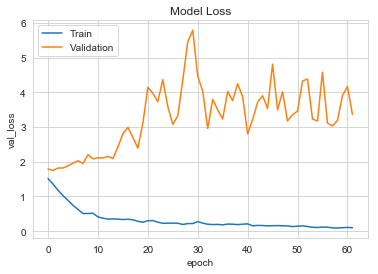

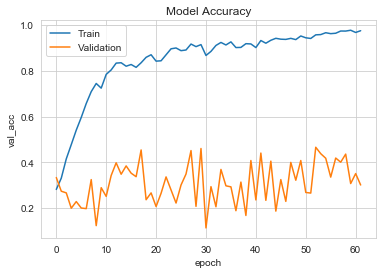

Loading Best Model
Train on 4422 samples, validate on 1101 samples
Epoch 1/1000
4422/4422 [==============================] - 4s 811us/step - loss: 1.8929 - acc: 0.1976 - val_loss: 2.0631 - val_acc: 0.2434
Epoch 2/1000
4422/4422 [==============================] - 3s 597us/step - loss: 1.5220 - acc: 0.2592 - val_loss: 1.7862 - val_acc: 0.2352
Epoch 3/1000
4422/4422 [==============================] - 3s 603us/step - loss: 1.3645 - acc: 0.3435 - val_loss: 1.8110 - val_acc: 0.2307
Epoch 4/1000
4422/4422 [==============================] - 3s 603us/step - loss: 1.2029 - acc: 0.3944 - val_loss: 1.8936 - val_acc: 0.2134
Epoch 5/1000
4422/4422 [==============================] - 3s 608us/step - loss: 1.0155 - acc: 0.4783 - val_loss: 2.0239 - val_acc: 0.2416
Epoch 6/1000
4422/4422 [==============================] - 3s 613us/step - loss: 0.8534 - acc: 0.5337 - val_loss: 2.1201 - val_acc: 0.2779
Epoch 7/1000
4422/4422 [==============================] - 3s 612us/step - loss: 0.7216 - acc: 0.6095 - va

4422/4422 [==============================] - 3s 628us/step - loss: 0.1177 - acc: 0.9559 - val_loss: 3.3689 - val_acc: 0.2816
Epoch 60/1000
4422/4422 [==============================] - 3s 687us/step - loss: 0.1007 - acc: 0.9724 - val_loss: 5.2744 - val_acc: 0.4541
Epoch 61/1000
4422/4422 [==============================] - 3s 630us/step - loss: 0.1167 - acc: 0.9462 - val_loss: 3.2570 - val_acc: 0.2443
Epoch 62/1000
4422/4422 [==============================] - 3s 664us/step - loss: 0.1274 - acc: 0.9604 - val_loss: 4.7080 - val_acc: 0.4514


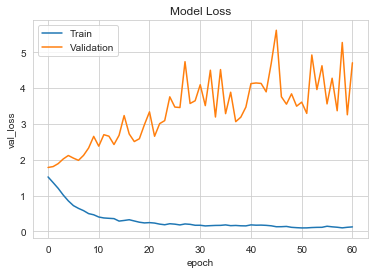

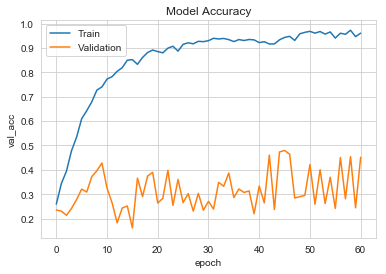

Loading Best Model
elapsed_time: 877.6667308807373


In [21]:
# Train the Extragalactic CNN Model

epochs = 1000
y_extragal_count = Counter(target_extragal_map)
wtable = np.zeros((len(classes_extragal),))
for i in range(len(classes_extragal)):
    wtable[i] = y_extragal_count[i] / target_extragal_map.shape[0]

y_extragal_map = target_extragal_map
y_extragal_categorical = Y_extragal
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
start = time.time()
clfs_extragal = []
oof_extragal_preds = np.zeros((len(X_extragal_train), len(classes_extragal)))

model_extragal_file = "model_extragal.weights"

for fold_, (trn_, val_) in enumerate(folds.split(y_extragal_map, y_extragal_map)):
    checkPoint = ModelCheckpoint(model_extragal_file, monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)

    x_extragal_train, y_extragal_train = X_extragal_train[trn_], Y_extragal[trn_]
    x_extragal_valid, y_extragal_valid = X_extragal_train[val_], Y_extragal[val_]

    model_extragal = build_model(X_extragal_train, classes_extragal)
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    stopping = EarlyStopping(monitor='val_loss', patience=60, verbose=0, mode='auto')

    model_extragal.compile(loss=mywloss, optimizer=optimizer, metrics=['accuracy'])
    history_extragal = model_extragal.fit(
        x_extragal_train, y_extragal_train,
        validation_data=[x_extragal_valid, y_extragal_valid],
        epochs=epochs,
        batch_size=batch_size,
        shuffle=False,verbose=1,callbacks=[checkPoint, stopping])
    plot_loss_acc(history_extragal)

    print('Loading Best Model')
    model_extragal.load_weights(model_extragal_file)
    # Get predicted probabilities for each class
    oof_extragal_preds[val_, :] = model_extragal.predict(x_extragal_valid, batch_size=batch_size)
    clfs_extragal.append(model_extragal)

elapsed_time = time.time() - start
print("elapsed_time:", elapsed_time)


Train on 1858 samples, validate on 467 samples
Epoch 1/1000
1858/1858 [==============================] - 2s 1ms/step - loss: 1.7697 - acc: 0.3886 - val_loss: 1.1004 - val_acc: 0.4218
Epoch 2/1000
1858/1858 [==============================] - 1s 605us/step - loss: 0.9906 - acc: 0.6442 - val_loss: 1.0226 - val_acc: 0.4582
Epoch 3/1000
1858/1858 [==============================] - 1s 607us/step - loss: 0.8690 - acc: 0.6970 - val_loss: 0.9171 - val_acc: 0.6702
Epoch 4/1000
1858/1858 [==============================] - 1s 719us/step - loss: 0.7860 - acc: 0.7137 - val_loss: 0.9117 - val_acc: 0.6724
Epoch 5/1000
1858/1858 [==============================] - 1s 635us/step - loss: 0.7439 - acc: 0.7228 - val_loss: 0.8811 - val_acc: 0.6681
Epoch 6/1000
1858/1858 [==============================] - 1s 614us/step - loss: 0.6821 - acc: 0.7352 - val_loss: 0.9061 - val_acc: 0.6681
Epoch 7/1000
1858/1858 [==============================] - 1s 619us/step - loss: 0.6328 - acc: 0.7487 - val_loss: 0.8952 - val_a

1858/1858 [==============================] - 1s 620us/step - loss: 0.1815 - acc: 0.9408 - val_loss: 0.5802 - val_acc: 0.7452
Epoch 60/1000
1858/1858 [==============================] - 1s 630us/step - loss: 0.1598 - acc: 0.9343 - val_loss: 0.6090 - val_acc: 0.7580
Epoch 61/1000
1858/1858 [==============================] - 1s 733us/step - loss: 0.1499 - acc: 0.9505 - val_loss: 0.6416 - val_acc: 0.7195
Epoch 62/1000
1858/1858 [==============================] - 1s 656us/step - loss: 0.2420 - acc: 0.9257 - val_loss: 0.8008 - val_acc: 0.6895
Epoch 63/1000
1858/1858 [==============================] - 1s 623us/step - loss: 0.2401 - acc: 0.9290 - val_loss: 0.7942 - val_acc: 0.6552
Epoch 64/1000
1858/1858 [==============================] - 1s 611us/step - loss: 0.2131 - acc: 0.9257 - val_loss: 0.8122 - val_acc: 0.6595
Epoch 65/1000
1858/1858 [==============================] - 1s 715us/step - loss: 0.1937 - acc: 0.9408 - val_loss: 0.7274 - val_acc: 0.6895
Epoch 66/1000
1858/1858 [================

Epoch 118/1000
1858/1858 [==============================] - 1s 703us/step - loss: 0.0479 - acc: 0.9919 - val_loss: 0.8232 - val_acc: 0.7388
Epoch 119/1000
1858/1858 [==============================] - 1s 676us/step - loss: 0.0504 - acc: 0.9909 - val_loss: 0.8836 - val_acc: 0.7366


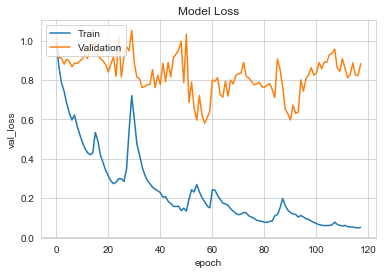

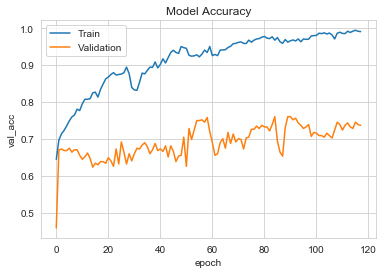

Loading Best Model
Train on 1860 samples, validate on 465 samples
Epoch 1/1000
1860/1860 [==============================] - 3s 1ms/step - loss: 2.8346 - acc: 0.1995 - val_loss: 1.4165 - val_acc: 0.1699
Epoch 2/1000
1860/1860 [==============================] - 1s 613us/step - loss: 1.2605 - acc: 0.4952 - val_loss: 1.2558 - val_acc: 0.2452
Epoch 3/1000
1860/1860 [==============================] - 1s 611us/step - loss: 0.9800 - acc: 0.6333 - val_loss: 1.2308 - val_acc: 0.5333
Epoch 4/1000
1860/1860 [==============================] - 1s 705us/step - loss: 0.8938 - acc: 0.6817 - val_loss: 1.2044 - val_acc: 0.6387
Epoch 5/1000
1860/1860 [==============================] - 1s 675us/step - loss: 0.8333 - acc: 0.6995 - val_loss: 1.1489 - val_acc: 0.6344
Epoch 6/1000
1860/1860 [==============================] - 1s 616us/step - loss: 0.7762 - acc: 0.7038 - val_loss: 1.1034 - val_acc: 0.6366
Epoch 7/1000
1860/1860 [==============================] - 1s 609us/step - loss: 0.7311 - acc: 0.7145 - val_l

1860/1860 [==============================] - 1s 632us/step - loss: 0.2251 - acc: 0.9269 - val_loss: 1.0404 - val_acc: 0.6366
Epoch 60/1000
1860/1860 [==============================] - 1s 646us/step - loss: 0.2187 - acc: 0.9387 - val_loss: 0.9288 - val_acc: 0.6516
Epoch 61/1000
1860/1860 [==============================] - 1s 746us/step - loss: 0.1984 - acc: 0.9301 - val_loss: 0.9211 - val_acc: 0.6323
Epoch 62/1000
1860/1860 [==============================] - 1s 635us/step - loss: 0.1879 - acc: 0.9366 - val_loss: 0.8882 - val_acc: 0.6753
Epoch 63/1000
1860/1860 [==============================] - 1s 618us/step - loss: 0.1546 - acc: 0.9446 - val_loss: 0.9287 - val_acc: 0.6946
Epoch 64/1000
1860/1860 [==============================] - 1s 615us/step - loss: 0.1532 - acc: 0.9468 - val_loss: 0.8065 - val_acc: 0.7376
Epoch 65/1000
1860/1860 [==============================] - 1s 724us/step - loss: 0.1388 - acc: 0.9414 - val_loss: 0.8224 - val_acc: 0.7441
Epoch 66/1000
1860/1860 [================

Epoch 118/1000
1860/1860 [==============================] - 1s 724us/step - loss: 0.6560 - acc: 0.8694 - val_loss: 4.5548 - val_acc: 0.0968
Epoch 119/1000
1860/1860 [==============================] - 1s 644us/step - loss: 0.6639 - acc: 0.7892 - val_loss: 3.6491 - val_acc: 0.1161
Epoch 120/1000
1860/1860 [==============================] - 1s 619us/step - loss: 0.6288 - acc: 0.7651 - val_loss: 2.7763 - val_acc: 0.1613
Epoch 121/1000
1860/1860 [==============================] - 1s 614us/step - loss: 0.4902 - acc: 0.8371 - val_loss: 2.1104 - val_acc: 0.3355
Epoch 122/1000
1860/1860 [==============================] - 1s 736us/step - loss: 0.4323 - acc: 0.8532 - val_loss: 1.7875 - val_acc: 0.5677
Epoch 123/1000
1860/1860 [==============================] - 1s 657us/step - loss: 0.4100 - acc: 0.8489 - val_loss: 1.6599 - val_acc: 0.5720
Epoch 124/1000
1860/1860 [==============================] - 1s 624us/step - loss: 0.3496 - acc: 0.8817 - val_loss: 1.2809 - val_acc: 0.5914
Epoch 125/1000
1860/

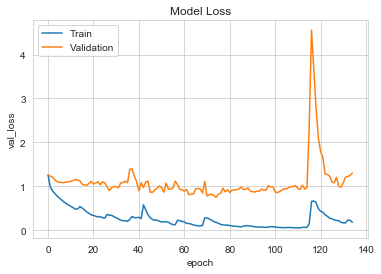

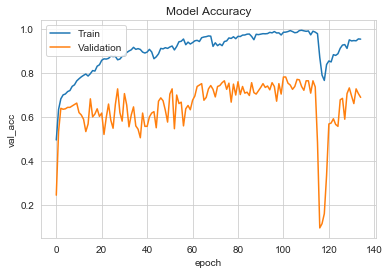

Loading Best Model
Train on 1860 samples, validate on 465 samples
Epoch 1/1000
1860/1860 [==============================] - 2s 1ms/step - loss: 1.5432 - acc: 0.3968 - val_loss: 1.3636 - val_acc: 0.3785
Epoch 2/1000
1860/1860 [==============================] - 1s 597us/step - loss: 0.9834 - acc: 0.6677 - val_loss: 1.2680 - val_acc: 0.6409
Epoch 3/1000
1860/1860 [==============================] - 1s 716us/step - loss: 0.8494 - acc: 0.6871 - val_loss: 0.9867 - val_acc: 0.6688
Epoch 4/1000
1860/1860 [==============================] - 1s 656us/step - loss: 0.7462 - acc: 0.7032 - val_loss: 0.8705 - val_acc: 0.6817
Epoch 5/1000
1860/1860 [==============================] - 1s 615us/step - loss: 0.6836 - acc: 0.7156 - val_loss: 0.8043 - val_acc: 0.6925
Epoch 6/1000
1860/1860 [==============================] - 1s 612us/step - loss: 0.6170 - acc: 0.7355 - val_loss: 0.7472 - val_acc: 0.7204
Epoch 7/1000
1860/1860 [==============================] - 1s 727us/step - loss: 0.5585 - acc: 0.7602 - val_l

1860/1860 [==============================] - 1s 628us/step - loss: 0.1109 - acc: 0.9527 - val_loss: 0.9240 - val_acc: 0.7935
Epoch 60/1000
1860/1860 [==============================] - 1s 747us/step - loss: 0.1215 - acc: 0.9715 - val_loss: 0.9456 - val_acc: 0.7183
Epoch 61/1000
1860/1860 [==============================] - 1s 649us/step - loss: 0.2195 - acc: 0.9215 - val_loss: 1.3178 - val_acc: 0.4860
Epoch 62/1000
1860/1860 [==============================] - 1s 623us/step - loss: 0.2081 - acc: 0.9446 - val_loss: 1.3391 - val_acc: 0.5011
Epoch 63/1000
1860/1860 [==============================] - 1s 635us/step - loss: 0.2067 - acc: 0.9382 - val_loss: 1.4430 - val_acc: 0.4839
Epoch 64/1000
1860/1860 [==============================] - 1s 742us/step - loss: 0.2176 - acc: 0.9360 - val_loss: 0.8239 - val_acc: 0.6581
Epoch 65/1000
1860/1860 [==============================] - 1s 648us/step - loss: 0.2015 - acc: 0.9183 - val_loss: 0.5490 - val_acc: 0.7785
Epoch 66/1000
1860/1860 [================

Epoch 118/1000
1860/1860 [==============================] - 1s 624us/step - loss: 0.0724 - acc: 0.9941 - val_loss: 1.0531 - val_acc: 0.7763
Epoch 119/1000
1860/1860 [==============================] - 1s 627us/step - loss: 0.0622 - acc: 0.9898 - val_loss: 0.9630 - val_acc: 0.7785
Epoch 120/1000
1860/1860 [==============================] - 1s 663us/step - loss: 0.0513 - acc: 0.9968 - val_loss: 0.9802 - val_acc: 0.8043
Epoch 121/1000
1860/1860 [==============================] - 1s 745us/step - loss: 0.0495 - acc: 0.9925 - val_loss: 0.9326 - val_acc: 0.8086
Epoch 122/1000
1860/1860 [==============================] - 1s 620us/step - loss: 0.0484 - acc: 0.9962 - val_loss: 0.9642 - val_acc: 0.8065
Epoch 123/1000
1860/1860 [==============================] - 1s 618us/step - loss: 0.0466 - acc: 0.9957 - val_loss: 0.9482 - val_acc: 0.8043
Epoch 124/1000
1860/1860 [==============================] - 1s 644us/step - loss: 0.0447 - acc: 0.9962 - val_loss: 1.0024 - val_acc: 0.7892
Epoch 125/1000
1860/

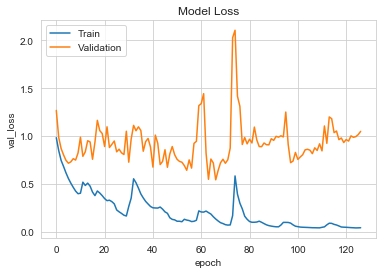

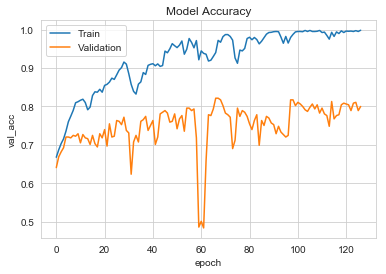

Loading Best Model
Train on 1860 samples, validate on 465 samples
Epoch 1/1000
1860/1860 [==============================] - 2s 1ms/step - loss: 1.8571 - acc: 0.4285 - val_loss: 1.1344 - val_acc: 0.5011
Epoch 2/1000
1860/1860 [==============================] - 1s 703us/step - loss: 1.2457 - acc: 0.6344 - val_loss: 1.0938 - val_acc: 0.6215
Epoch 3/1000
1860/1860 [==============================] - 1s 598us/step - loss: 0.9678 - acc: 0.6849 - val_loss: 1.0600 - val_acc: 0.5978
Epoch 4/1000
1860/1860 [==============================] - 1s 611us/step - loss: 0.8585 - acc: 0.6952 - val_loss: 1.0350 - val_acc: 0.5978
Epoch 5/1000
1860/1860 [==============================] - 1s 649us/step - loss: 0.7644 - acc: 0.7177 - val_loss: 0.9840 - val_acc: 0.6452
Epoch 6/1000
1860/1860 [==============================] - 1s 717us/step - loss: 0.6854 - acc: 0.7231 - val_loss: 0.9590 - val_acc: 0.6366
Epoch 7/1000
1860/1860 [==============================] - 1s 612us/step - loss: 0.6388 - acc: 0.7312 - val_l

1860/1860 [==============================] - 1s 690us/step - loss: 0.1464 - acc: 0.9543 - val_loss: 0.9995 - val_acc: 0.7226
Epoch 60/1000
1860/1860 [==============================] - 1s 620us/step - loss: 0.1367 - acc: 0.9543 - val_loss: 1.1742 - val_acc: 0.6731
Epoch 61/1000
1860/1860 [==============================] - 1s 620us/step - loss: 0.1261 - acc: 0.9522 - val_loss: 1.1494 - val_acc: 0.7484
Epoch 62/1000
1860/1860 [==============================] - 1s 700us/step - loss: 0.1118 - acc: 0.9640 - val_loss: 1.0873 - val_acc: 0.7505
Epoch 63/1000
1860/1860 [==============================] - 1s 698us/step - loss: 0.1002 - acc: 0.9634 - val_loss: 1.1703 - val_acc: 0.6946
Epoch 64/1000
1860/1860 [==============================] - 1s 622us/step - loss: 0.0945 - acc: 0.9661 - val_loss: 1.1318 - val_acc: 0.6989
Epoch 65/1000
1860/1860 [==============================] - 1s 618us/step - loss: 0.0986 - acc: 0.9613 - val_loss: 1.1653 - val_acc: 0.7032
Epoch 66/1000
1860/1860 [================

Epoch 118/1000
1860/1860 [==============================] - 1s 611us/step - loss: 0.1042 - acc: 0.9629 - val_loss: 1.0650 - val_acc: 0.7333
Epoch 119/1000
1860/1860 [==============================] - 1s 715us/step - loss: 0.1532 - acc: 0.9591 - val_loss: 1.4029 - val_acc: 0.6194
Epoch 120/1000
1860/1860 [==============================] - 1s 676us/step - loss: 0.1512 - acc: 0.9720 - val_loss: 1.2435 - val_acc: 0.6774
Epoch 121/1000
1860/1860 [==============================] - 1s 624us/step - loss: 0.1302 - acc: 0.9763 - val_loss: 1.1316 - val_acc: 0.7011
Epoch 122/1000
1860/1860 [==============================] - 1s 619us/step - loss: 0.1225 - acc: 0.9699 - val_loss: 1.1406 - val_acc: 0.7011
Epoch 123/1000
1860/1860 [==============================] - 1s 721us/step - loss: 0.1149 - acc: 0.9742 - val_loss: 1.1698 - val_acc: 0.6753
Epoch 124/1000
1860/1860 [==============================] - 1s 683us/step - loss: 0.0964 - acc: 0.9780 - val_loss: 1.1766 - val_acc: 0.7183
Epoch 125/1000
1860/

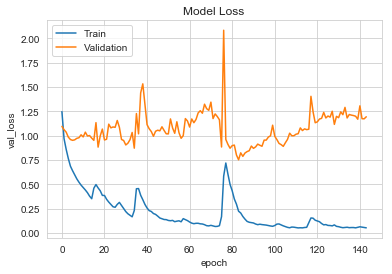

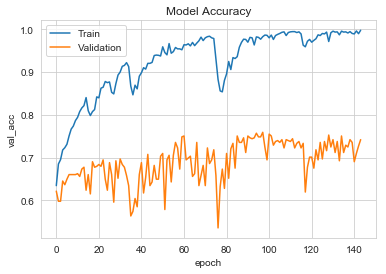

Loading Best Model
Train on 1862 samples, validate on 463 samples
Epoch 1/1000
1862/1862 [==============================] - 3s 1ms/step - loss: 2.1027 - acc: 0.4791 - val_loss: 1.3207 - val_acc: 0.5659
Epoch 2/1000
1862/1862 [==============================] - 1s 608us/step - loss: 0.9101 - acc: 0.6547 - val_loss: 1.2339 - val_acc: 0.5875
Epoch 3/1000
1862/1862 [==============================] - 1s 720us/step - loss: 0.7820 - acc: 0.6923 - val_loss: 1.1900 - val_acc: 0.5745
Epoch 4/1000
1862/1862 [==============================] - 1s 624us/step - loss: 0.7178 - acc: 0.7084 - val_loss: 1.1777 - val_acc: 0.5853
Epoch 5/1000
1862/1862 [==============================] - 1s 611us/step - loss: 0.6814 - acc: 0.7197 - val_loss: 1.1782 - val_acc: 0.5594
Epoch 6/1000
1862/1862 [==============================] - 1s 623us/step - loss: 0.6940 - acc: 0.7234 - val_loss: 1.1455 - val_acc: 0.5724
Epoch 7/1000
1862/1862 [==============================] - 1s 724us/step - loss: 0.6420 - acc: 0.7417 - val_l

1862/1862 [==============================] - 1s 682us/step - loss: 0.0888 - acc: 0.9683 - val_loss: 2.4761 - val_acc: 0.5227
Epoch 60/1000
1862/1862 [==============================] - 1s 730us/step - loss: 0.0840 - acc: 0.9678 - val_loss: 2.4419 - val_acc: 0.5335
Epoch 61/1000
1862/1862 [==============================] - 1s 627us/step - loss: 0.0803 - acc: 0.9715 - val_loss: 2.4938 - val_acc: 0.5400
Epoch 62/1000
1862/1862 [==============================] - 1s 630us/step - loss: 0.0774 - acc: 0.9699 - val_loss: 2.4995 - val_acc: 0.5421
Epoch 63/1000
1862/1862 [==============================] - 1s 688us/step - loss: 0.0880 - acc: 0.9710 - val_loss: 1.9762 - val_acc: 0.6242
Epoch 64/1000
1862/1862 [==============================] - 1s 724us/step - loss: 0.3780 - acc: 0.9608 - val_loss: 1.4403 - val_acc: 0.6091
Epoch 65/1000
1862/1862 [==============================] - 1s 621us/step - loss: 0.7014 - acc: 0.8808 - val_loss: 1.5773 - val_acc: 0.6933
Epoch 66/1000
1862/1862 [================

Epoch 118/1000
1862/1862 [==============================] - 1s 632us/step - loss: 0.1210 - acc: 0.9844 - val_loss: 2.2219 - val_acc: 0.6263
Epoch 119/1000
1862/1862 [==============================] - 1s 627us/step - loss: 0.1244 - acc: 0.9855 - val_loss: 2.0689 - val_acc: 0.6955
Epoch 120/1000
1862/1862 [==============================] - 1s 726us/step - loss: 0.1264 - acc: 0.9791 - val_loss: 2.2625 - val_acc: 0.6156
Epoch 121/1000
1862/1862 [==============================] - 1s 683us/step - loss: 0.1284 - acc: 0.9860 - val_loss: 2.1178 - val_acc: 0.6847
Epoch 122/1000
1862/1862 [==============================] - 1s 623us/step - loss: 0.1254 - acc: 0.9769 - val_loss: 2.1741 - val_acc: 0.6436
Epoch 123/1000
1862/1862 [==============================] - 1s 615us/step - loss: 0.1228 - acc: 0.9823 - val_loss: 2.1888 - val_acc: 0.6544
Epoch 124/1000
1862/1862 [==============================] - 1s 701us/step - loss: 0.1201 - acc: 0.9876 - val_loss: 2.2845 - val_acc: 0.6393
Epoch 125/1000
1862/

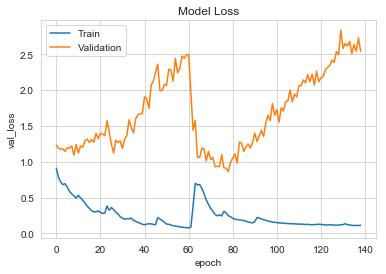

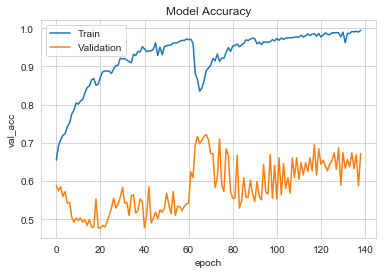

Loading Best Model
elapsed_time: 843.1479001045227


In [22]:
# Train the Intragalactic CNN Model

epochs = 1000
y_intragal_count = Counter(target_intragal_map)
wtable = np.zeros((len(classes_intragal),))
for i in range(len(classes_intragal)):
    wtable[i] = y_intragal_count[i] / target_intragal_map.shape[0]

y_intragal_map = target_intragal_map
y_intragal_categorical = Y_intragal
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
start = time.time()
clfs_intragal = []
oof_intragal_preds = np.zeros((len(X_intragal_train), len(classes_intragal)))

model_intragal_file = "model_intragal.weights"

for fold_, (trn_, val_) in enumerate(folds.split(y_intragal_map, y_intragal_map)):
    checkPoint = ModelCheckpoint(model_intragal_file, monitor='val_loss', mode = 'min', save_best_only=True, verbose=0)

    x_intragal_train, y_intragal_train = X_intragal_train[trn_], Y_intragal[trn_]
    x_intragal_valid, y_intragal_valid = X_intragal_train[val_], Y_intragal[val_]

    model_intragal = build_model(X_intragal_train, classes_intragal)
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    stopping = EarlyStopping(monitor='val_loss', patience=60, verbose=0, mode='auto')

    model_intragal.compile(loss=mywloss, optimizer=optimizer, metrics=['accuracy'])
    history_intragal = model_intragal.fit(
        x_intragal_train, y_intragal_train,
        validation_data=[x_intragal_valid, y_intragal_valid],
        epochs=epochs,
        batch_size=batch_size,
        shuffle=False,verbose=1, callbacks=[checkPoint, stopping])
    plot_loss_acc(history_intragal)

    print('Loading Best Model')
    model_intragal.load_weights(model_intragal_file)
    # Get predicted probabilities for each class
    oof_intragal_preds[val_, :] = model_intragal.predict(x_intragal_valid, batch_size=batch_size)
    clfs_intragal.append(model_intragal)

elapsed_time = time.time() - start
print("elapsed_time:", elapsed_time)

In [47]:
classes = [53, 64, 6, 95, 52, 67, 92, 88, 62, 15, 16, 65, 42, 90]

def convert_sub_class_to_full_class_prob(arr):
    if len(arr) == 5:
        return np.array([arr[2], 0., arr[0], 0., 0., 0., arr[4], 0., 0., 0., arr[1], arr[3], 0., 0.])
    elif len(arr) == 9:
        return np.array([0., arr[4], 0., arr[8], arr[2], arr[5], 0., arr[6], arr[3], arr[0], 0., 0., arr[1], arr[7]])
    else:
        return np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

def convert_full_class_prob_to_class_pred(arr):
    max_index = arr.argmax(axis=0)
    return classes[max_index]

In [49]:
Y_pred = []
Y_test = []

for pred in oof_intragal_preds:
    full_class_pred = convert_sub_class_to_full_class_prob(pred)
    Y_pred.append(convert_full_class_prob_to_class_pred(full_class_pred))
for pred in oof_extragal_preds:
    full_class_pred = convert_sub_class_to_full_class_prob(pred)
    Y_pred.append(convert_full_class_prob_to_class_pred(full_class_pred))

for target in y_intragal_valid:
    full_class_target = convert_sub_class_to_full_class_prob(pred)
    Y_test.append(convert_full_class_prob_to_class_pred(full_class_pred))
for target in y_extragal_valid:
    full_class_target = convert_sub_class_to_full_class_prob(pred)
    Y_test.append(convert_full_class_prob_to_class_pred(full_class_pred))

[92,
 65,
 65,
 65,
 16,
 65,
 65,
 65,
 16,
 65,
 92,
 65,
 65,
 65,
 65,
 65,
 65,
 16,
 65,
 92,
 65,
 65,
 65,
 65,
 65,
 16,
 65,
 92,
 16,
 6,
 6,
 92,
 65,
 65,
 65,
 65,
 16,
 92,
 65,
 16,
 65,
 92,
 92,
 92,
 16,
 65,
 16,
 65,
 16,
 65,
 65,
 92,
 65,
 65,
 65,
 65,
 65,
 65,
 65,
 16,
 65,
 16,
 65,
 16,
 65,
 65,
 16,
 16,
 92,
 16,
 65,
 65,
 16,
 65,
 65,
 65,
 65,
 16,
 16,
 92,
 65,
 92,
 16,
 65,
 16,
 65,
 65,
 65,
 65,
 92,
 65,
 65,
 65,
 65,
 65,
 65,
 65,
 65,
 65,
 65,
 65,
 65,
 16,
 92,
 65,
 16,
 65,
 92,
 92,
 65,
 92,
 16,
 65,
 65,
 92,
 16,
 92,
 65,
 16,
 65,
 65,
 16,
 16,
 16,
 65,
 92,
 65,
 65,
 92,
 92,
 65,
 65,
 65,
 16,
 65,
 65,
 16,
 65,
 16,
 65,
 65,
 16,
 65,
 6,
 65,
 16,
 92,
 65,
 92,
 65,
 65,
 65,
 65,
 16,
 65,
 92,
 16,
 65,
 16,
 65,
 65,
 65,
 16,
 65,
 16,
 65,
 92,
 16,
 16,
 65,
 65,
 92,
 65,
 65,
 65,
 65,
 65,
 65,
 65,
 65,
 65,
 16,
 65,
 92,
 92,
 92,
 16,
 92,
 65,
 65,
 65,
 65,
 65,
 65,
 65,
 16,
 16,
 65,
 65,
 65,
 65

# Results

## Model Evaluation and Validation

## Justification

# Conclusion

## Free-Form Visualization

## Reflection

## Improvement

<a id='references'></a>

# References

<a name="reference-1"></a>[1] - [PLAsTiCC Astronomy Starter Kit](https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit)